## Example export to SPRING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures



/Users/sam/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data prep

Download counts matrices from 10X

In [ ]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
!tar xfz pbmc8k_filtered_gene_bc_matrices.tar.gz


Load data

In [2]:
path = 'filtered_gene_bc_matrices/GRCh38/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # first time only
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.var_names_make_unique()

... reading from cache file ./cache/filtered_gene_bc_matrices-GRCh38-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Store total counts

In [3]:
adata.obs['n_counts'] = adata.X.sum(1).A1

Normalize, then store full normalized counts matrix

In [4]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=adata.obs['n_counts'].mean())

In [5]:
adata.raw = adata

Filter genes

In [6]:
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)


In [8]:
filter_result['gene_subset'].sum()

1189

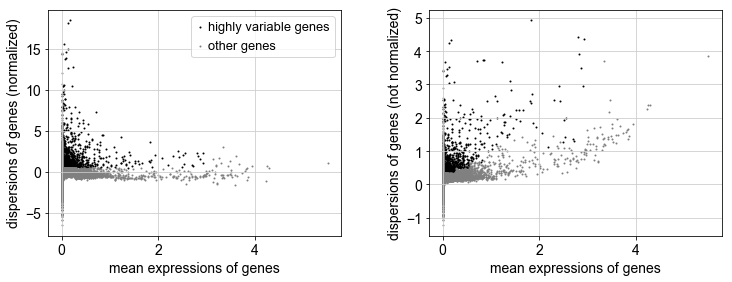

In [9]:
sc.pl.filter_genes_dispersion(filter_result)

In [10]:
adata = adata[:, filter_result.gene_subset]


Z-score normalize and run PCA

In [11]:
sc.pp.scale(adata)


In [12]:
sc.tl.pca(adata)


Build k-nearest-neighbor graph

In [13]:
sc.pp.neighbors(adata, n_neighbors=5, use_rep='X_pca')

computing neighbors
    finished (0:00:05.61)


Get some 2-D embeddings - umap and force-directed graph

In [14]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:09.11)


In [15]:
sc.tl.draw_graph(adata, layout='fa')

drawing single-cell graph using layout "fa"
    finished (0:00:45.86)


Cluster and run graph abstraction

In [16]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.80)


In [17]:
sc.tl.paga(adata, groups='louvain')


running partition-based graph abstraction (PAGA)
    finished (0:00:00.07)


### Export SPRING plot

First, export a subplot using the ForceAtlas2 layout

In [18]:
import time
t0 = time.time()
sc.export_to.spring_project(adata, './10x_pbmc8k', 'draw_graph', subplot_name='force')
print(time.time() - t0)

Writing subplot to ./10x_pbmc8k/force/
41.813865184783936


Repeat export, this time using umap embedding.  
Should be much faster since hdf5 counts matrices do not need to be rewritten.

In [19]:
t0 = time.time()
sc.export_to.spring_project(adata, './10x_pbmc8k', 'umap', subplot_name='umap')
print(time.time() - t0)

Writing subplot to ./10x_pbmc8k/umap/
./10x_pbmc8k/ is an existing SPRING folder. A new subplot will be created, but you must set `overwrite=True` to overwrite counts matrices.
2.749732255935669
